In [144]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [145]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [146]:
missing_train = train.isnull().sum().sort_values(ascending=False)
missing_test = test.isnull().sum().sort_values(ascending=False)

#print(missing_train[missing_train > 0])
#print(missing_test[missing_test > 0])
train = train.drop(columns=['Alley','MasVnrType','FireplaceQu','PoolQC','Fence','MiscFeature','LotFrontage'])
test =test.drop(columns=['Alley','MasVnrType','FireplaceQu','PoolQC','Fence','MiscFeature','LotFrontage'])





In [147]:
train = pd.get_dummies(train)


In [148]:
correlation_matrix = train.corr()

correlation_with_saleprice = correlation_matrix['SalePrice'].sort_values(ascending=False)
correlation_with_saleprice[(correlation_with_saleprice>0.5) | (correlation_with_saleprice<-0.5)]
correlation_with_saleprice = correlation_with_saleprice[(correlation_with_saleprice>0.5) | (correlation_with_saleprice<-0.5)] [1:]
correlation_with_saleprice

OverallQual       0.790982
GrLivArea         0.708624
GarageCars        0.640409
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
FullBath          0.560664
BsmtQual_Ex       0.553105
TotRmsAbvGrd      0.533723
YearBuilt         0.522897
YearRemodAdd      0.507101
KitchenQual_Ex    0.504094
KitchenQual_TA   -0.519298
ExterQual_TA     -0.589044
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Id'>

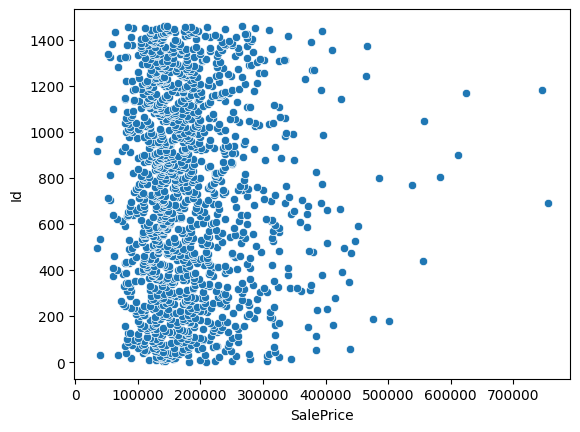

In [149]:
sb.scatterplot(x=train['SalePrice'],y=train['Id'])

<Axes: xlabel='SalePrice', ylabel='Id'>

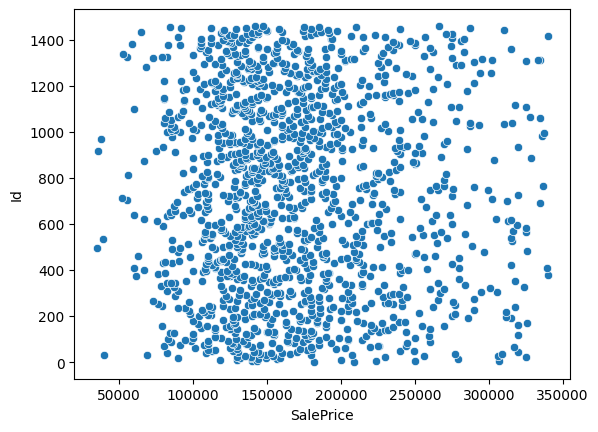

In [150]:
q1,q3 =np.quantile(train['SalePrice'], 0.25),np.quantile(train['SalePrice'], 0.75)
IQR = q3-q1
q3=q3+1.5*IQR
q1=q1-1.5*IQR
train = train[(train['SalePrice']<=q3)&(train['SalePrice']>=q1)]
sb.scatterplot(x=train['SalePrice'],y=train['Id'])

In [151]:
import lightgbm as lgb
model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05)
model.fit(train[list(correlation_with_saleprice.index)], train['SalePrice'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1217
[LightGBM] [Info] Number of data points in the train set: 1399, number of used features: 14
[LightGBM] [Info] Start training from score 170237.127234


LGBMRegressor(learning_rate=0.05, n_estimators=1000)

In [152]:
test = pd.get_dummies(test)


In [153]:
selected_columns = train[list(correlation_with_saleprice.index)].columns
pr = model.predict(test[selected_columns])

In [154]:
submission = pd.DataFrame({
    'Id': test['Id'],         
    'SalePrice': pr
})

In [155]:
submission.to_csv('submission.csv', index=False)
